In [223]:
# Import libraries
import requests
import numpy as np
import pandas as pd
from datetime import datetime, date, time
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

In [224]:
# reads in bitcoin data from a downloaded csv file
bitcoin = pd.read_csv("C:\\Qilin\\Python\\CryptoReturnsModelling\\btc-usd-max.csv")

# modifies indexes to get rid of timezone format and reindex to given values in csv
bitcoin['snapped_at'] = pd.to_datetime(bitcoin.snapped_at).dt.tz_localize(None)
bitcoin.index = bitcoin['snapped_at']

# resamples data to last of the month
bitcoin = bitcoin.resample('M').last()

# deletes original index reference column and creates returns column
del bitcoin['snapped_at']
bitcoin['Returns'] = bitcoin['price'].pct_change().cumsum().fillna(0)

# display data
bitcoin.head()

,price,market_cap,total_volume,Returns
snapped_at,,,,
2013-04-30,135.3000,1.501657e+09,0.0,0.000000
2013-05-31,127.9800,1.436387e+09,0.0,-0.054102
2013-06-30,95.3886,1.082694e+09,0.0,-0.308762
2013-07-31,110.3400,1.267183e+09,0.0,-0.152020
2013-08-31,137.7600,1.602407e+09,0.0,0.096485


In [225]:
# full coin list
coin_list = ['BTC', 'ETH', 'XRP', 'BCH', 'ADA', 
             'XLM', 'NEO', 'LTC', 'EOS', 'XEM', 'IOTA', 
             'DASH', 'XMR', 'TRX', 'ICX', 'ETC', 'QTUM', 
             'BTG', 'LSK', 'USDT', 'OMG', 'ZEC', 'SC', 'ZRX', 
             'REP', 'WAVES', 'MKR', 'DCR', 'BAT', 'LRC', 
             'KNC', 'BNT', 'LINK', 'CVC', 'RLC', 'ENJ', 'STORJ', 
             'ANT', 'SNGLS', 'MANA', 'MLN', 'DNT', 'AMP', 'NMR', 
             'DOT', 'DAI', 'UNI', 'ATOM', 'GRT', 'LUNA', 'XTZ', 
             'FIL', 'NANO', 'WBTC', 'BSV', 'DOGE', 'USDC', 'OXT', 
             'ALGO', 'BAND', 'BTT', 'FET', 'KAVA', 'PAX', 'PAXG', 
             'REN', 'AAVE', 'YFI', 'NU', 'MATIC', 'ICP', 'SOL', 'SUSHI', 
             'UMA', 'SNX', 'CRV', 'COMP', 'CELO', 'KSM', 'NKN', 'SHIB', 
             'SKL', 'SAND', 'UST', 'AVAX', 'IOTX', 'AXS', 'XYO', 
             'ANKR', 'CHZ', 'LPT', 'COTI', 'KEEP']

# get rid of USDT - stablecoin
# DOT - from ETH polkadot gavin woods, solidity
# USDC - stablecoin
# PAX - stablecoin

# Shorter CoinDesk 20
coindesk_20 = ['BTC', 'ETH', 'XRP', 'ADA', 'USDT', 'DOGE', 
               'XLM', 'DOT', 'UNI', 'LINK', 'USDC', 'BCH', 
               'LTC', 'GRT', 'ETC', 'FIL', 'AAVE', 'ALGO', 'EOS']

In [226]:
# creates coin-returns list to average all
def returns(df):
    coin_returns = []
    returns_df = pd.DataFrame(index=df.index);
    for coin in df:
        name = coin + '_returns'
        returns_df[name] = df[coin].pct_change()
        
        # excludes stable coins
        # if abs(returns_df[name].iloc[-1]) < 1:
            # continue
        coin_returns.append(name)
    return returns_df

def monthlyReturns(data):
    df = data.copy()
    df['avgMonthlyReturns'] = df.mean(axis=1)
    return df

def cumulativeReturns(data, name):
    df = data.copy()
    df['cumulative_' + name] = (1 + df[name]).cumprod().fillna(0) - 1
    return df

# now we rebalance with top 5 performers each month
def portfolio(data, numStocks):
    df = data.copy()
    
    avg_returns = []
    top = []
    # loops through each row
    for i in range(len(df)):
        # for the first couple rows there will be less than 5 coins
        # in that case we take the mean of those coins performances
        if df.iloc[i,:].count() < 5:
            meanval = df.iloc[i,:].mean()
            avg_returns.append(meanval)
        
        # otherwise we take the mean of the top 5 from the previous month
        else: 
            avg_returns.append(df[top].iloc[i,:].mean())
        
        # create new top 5 for next month
        top = df.iloc[i,:].sort_values(ascending=False)[:numStocks].index.values.tolist()
        
    returns_df = pd.DataFrame(np.array(avg_returns), columns=['monthly_returns'], index=df.index)
    return returns_df

# finds CAGR of returns column
def CAGR(df):
    n = len(df) / 12
    cagr = (df['cumulative_returns'][len(df)-1])**(1/n) - 1
    return CAGR

In [227]:
# Setting dataframes
raw_df = pd.DataFrame()
for coin in coin_list:
    # individual coin dataframe
    df = pd.DataFrame(index=[0])
    
    # Define start and end times
    enddate = datetime.combine(date.today(), time())
    startdate = datetime(2013, 1, 1, 0, 0)
    
    # get url based on start and end
    url = 'https://production.api.coindesk.com/v2/price/values/' + coin + '?start_date=' + \
            startdate.strftime("%Y-%m-%dT%H:%M") + \
            '&end_date=' + enddate.strftime("%Y-%m-%dT%H:%M") + '&ohlc=false'
    
    # request json data
    temp_data_json = requests.get(url)
    temp_data = temp_data_json.json()
    df = pd.DataFrame(temp_data['data']['entries'])
    df.columns = ['Timestamp', 'Close']
    
    # redo timestamp labelling
    df = df.drop(['Timestamp'], axis=1)
    # loops values by end date
    df['Datetime'] = [enddate - relativedelta(days=len(df)-i) for i in range(0, len(df))]
    df['Datetime'] = pd.to_datetime(df.Datetime).dt.tz_localize(None)
    df.index = pd.to_datetime(df['Datetime'])
    
    # resamples the data monthly and then indexes to match bitcoin index
    df = df.resample('M').last()
    
    # sets symbol column to coin name and adds df to overall
    df['Symbol'] = coin
    raw_df = raw_df.append(df)

# creates pivot table with new columns of symbol and values of close
raw_df = raw_df[['Datetime', 'Symbol', 'Close']]
print(raw_df)
crypto_df = raw_df.pivot(index='Datetime', columns='Symbol', values='Close')

             Datetime Symbol        Close
Datetime                                 
2013-10-31 2013-10-31    BTC   197.400000
2013-11-30 2013-11-30    BTC  1068.363000
2013-12-31 2013-12-31    BTC   752.820220
2014-01-31 2014-01-31    BTC   832.873990
2014-02-28 2014-02-28    BTC   573.102500
...               ...    ...          ...
2021-12-31 2021-12-31   KEEP     0.724230
2022-01-31 2022-01-31   KEEP     0.448600
2022-02-28 2022-02-28   KEEP     0.796413
2022-03-31 2022-03-31   KEEP     0.656280
2022-04-30 2022-04-13   KEEP     0.561906

[2094 rows x 3 columns]


In [228]:
# writes output to csv
out_path = r"C:\Qilin\Python\CryptoReturnsModelling\out\CoinDesk20.csv"
crypto_df.to_csv(out_path)

In [229]:
# gets data from saved excel
in_path = r"C:\Qilin\Python\CryptoReturnsModelling\out\CoinDesk20.csv"
df = pd.read_csv(in_path)
df.index = pd.to_datetime(df['Datetime'])
df = df.drop(['Datetime'], axis=1)

returns_df = returns(df)
all_df = monthlyReturns(returns_df)
all_df = cumulativeReturns(all_df, 'avgMonthlyReturns')
all_df = cumulativeReturns(all_df, 'BTC_returns')
print(all_df)

# writes output to csv
out_path = r"C:\Qilin\Python\CryptoReturnsModelling\out\MonthlyReturns.csv"
all_df.to_csv(out_path)

            AAVE_returns  ADA_returns  ALGO_returns  AMP_returns  \
Datetime                                                           
2013-10-31           NaN          NaN           NaN          NaN   
2013-11-30           NaN          NaN           NaN          NaN   
2013-12-31           NaN          NaN           NaN          NaN   
2014-01-31           NaN          NaN           NaN          NaN   
2014-02-28           NaN          NaN           NaN          NaN   
...                  ...          ...           ...          ...   
2021-12-31     -0.004309    -0.165567     -0.089367    -0.220316   
2022-01-31     -0.386870    -0.196374     -0.431791    -0.376231   
2022-02-28     -0.078476    -0.079794     -0.092041    -0.018349   
2022-03-31      0.428746     0.193302      0.081035    -0.076698   
2022-04-13     -0.135585    -0.156501     -0.201501    -0.133370   

            ANKR_returns  ANT_returns  ATOM_returns  AVAX_returns  \
Datetime                                      

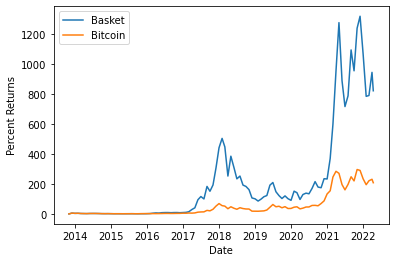

In [230]:
# plots basket returns in blue
plt.plot(all_df['cumulative_avgMonthlyReturns'], label="Basket")

# finds and plots bitcoin returns in orange
plt.plot(all_df['cumulative_BTC_returns'], label="Bitcoin")

# relabels axes and creates legend
plt.xlabel("Date")
plt.ylabel("Percent Returns")
plt.legend()

# save figure
outgraph = r"C:\Qilin\Python\CryptoReturnsModelling\out\Returns.png"
plt.savefig(outgraph)

plt.show()

In [231]:
# driver code
topFive = portfolio(returns_df, 5)
topFive = cumulativeReturns(topFive, 'monthly_returns')
print(topFive)

            monthly_returns  cumulative_monthly_returns
Datetime                                               
2013-10-31              NaN                   -1.000000
2013-11-30         4.412173                    4.412173
2013-12-31        -0.295352                    2.813679
2014-01-31         0.106338                    3.219220
2014-02-28        -0.311898                    1.903255
...                     ...                         ...
2021-12-31        -0.155332                 1808.388491
2022-01-31        -0.309739                 1247.949933
2022-02-28        -0.018611                 1224.706204
2022-03-31         0.569812                 1923.128267
2022-04-13        -0.296705                 1352.230075

[103 rows x 2 columns]


This looks really suspicious but considering the explosive performance of cryptocurrencies is not out of consideration. It is still a work in progress and will be optimized to be more realistic

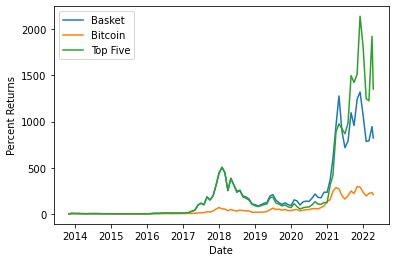

In [232]:
# Comparing rebalanced 5 to bitcoin and previous basket
# plots basket returns in blue
plt.plot(all_df['cumulative_avgMonthlyReturns'], label="Basket")

# plots bitcoin returns in orange
plt.plot(all_df['cumulative_BTC_returns'], label="Bitcoin")

# plots rebalanced in green
plt.plot(topFive['cumulative_monthly_returns'], label='Top Five')

# relabels axes and creates legend
plt.xlabel("Date")
plt.ylabel("Percent Returns")
plt.legend()

# save figure
outgraph = r"C:\Qilin\Python\CryptoReturnsModelling\out\Returns.png"
plt.savefig(outgraph)

plt.show()

Use last month, year, 6 months in order to rebalance
Also try to graph top 5, top 3, top 10
Save monthly returns to csv and send
Mike Novagra

In [233]:
# modified portfolio rebalancing to include lookback periods
def rebalancing(data, months, numStocks):
    df = data.copy()
    
    avg_returns = []
    top = []
    # loops through each row
    for i in range(months, len(df)):
        # for the first couple rows there will be less than 5 coins
        # in that case we take the mean of those coins performances
        if df.iloc[i,:].count() < numStocks:
            meanval = df.iloc[i,:].mean()
            avg_returns.append(meanval)
        
        # otherwise we take the mean of the top from the previous month
        else:
            avg_returns.append(df[top].iloc[i,:].mean())
        
        # creates new top 5 for next month based on top stocks returns for specified months looking back
        # first make list of average returns for all stocks for look back period
        avg_months = df.iloc[(i - months + 1):(i+1),:].mean(axis=0)
        
        # then sort list by top number of stocks
        top = avg_months.sort_values(ascending=False)[:numStocks].index.values.tolist()
    returns_df = pd.DataFrame(np.array(avg_returns), columns=['monthly_returns'], index=df.iloc[months:].index)
    return returns_df

In [234]:
# testing for rebalancing method
topFive_1Months = rebalancing(returns_df, 1, 5)
topFive_1Months = cumulativeReturns(topFive_1Months, 'monthly_returns')
print(topFive_1Months)

            monthly_returns  cumulative_monthly_returns
Datetime                                               
2013-11-30         4.412173                    4.412173
2013-12-31        -0.295352                    2.813679
2014-01-31         0.106338                    3.219220
2014-02-28        -0.311898                    1.903255
2014-03-31        -0.150574                    1.466102
...                     ...                         ...
2021-12-31        -0.155332                 1808.388491
2022-01-31        -0.309739                 1247.949933
2022-02-28        -0.018611                 1224.706204
2022-03-31         0.569812                 1923.128267
2022-04-13        -0.296705                 1352.230075

[102 rows x 2 columns]


In [235]:
# driver code, we'll graph 1 month standard, 3 months, 6 months, and 12 months (year)
topFive_1Months = rebalancing(returns_df, 1, 5)
topFive_2Months = rebalancing(returns_df, 2, 5)
topFive_3Months = rebalancing(returns_df, 3, 5)
topFive_6Months = rebalancing(returns_df, 6, 5)
topFive_12Months = rebalancing(returns_df, 12, 5)

# compare cumulative returns by having the same starting date
# these returns will no longer have bitcoin's 400% return from the first month
topFive_1Months = cumulativeReturns(topFive_1Months.iloc[12:], 'monthly_returns')
topFive_2Months = cumulativeReturns(topFive_2Months.iloc[10:], 'monthly_returns')
topFive_3Months = cumulativeReturns(topFive_3Months.iloc[9:], 'monthly_returns')
topFive_6Months = cumulativeReturns(topFive_6Months.iloc[6:], 'monthly_returns')
topFive_12Months = cumulativeReturns(topFive_12Months, 'monthly_returns')

print(topFive_1Months)
print(topFive_2Months)
print(topFive_3Months)
print(topFive_6Months)
print(topFive_12Months)

            monthly_returns  cumulative_monthly_returns
Datetime                                               
2014-11-30         0.118925                    0.118925
2014-12-31        -0.163664                   -0.064202
2015-01-31        -0.257499                   -0.305169
2015-02-28         0.077842                   -0.251082
2015-03-31        -0.024576                   -0.269488
...                     ...                         ...
2021-12-31        -0.155332                 1063.484949
2022-01-31        -0.309739                  733.772224
2022-02-28        -0.018611                  720.097660
2022-03-31         0.569812                 1130.987736
2022-04-13        -0.296705                  795.121483

[90 rows x 2 columns]
            monthly_returns  cumulative_monthly_returns
Datetime                                               
2014-10-31        -0.112288                   -0.112288
2014-11-30         0.118925                   -0.006717
2014-12-31        -0.1636

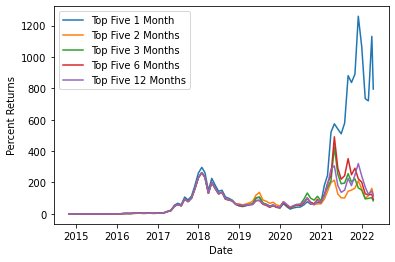

In [236]:
# graphs for each 1 month, 3 month, 6 month, and 1 year lookback balanced returns
# Comparing rebalanced 5 to bitcoin and previous basket
# plots top five 1 month lookback returns in blue
plt.plot(topFive_1Months['cumulative_monthly_returns'], label='Top Five 1 Month')

# plots top five two month lookback returns in orange
plt.plot(topFive_2Months['cumulative_monthly_returns'], label='Top Five 2 Months')

# plots top five 3 month lookback returns in green
plt.plot(topFive_3Months['cumulative_monthly_returns'], label='Top Five 3 Months')

# plots top five 3 month lookback returns in red
plt.plot(topFive_6Months['cumulative_monthly_returns'], label='Top Five 6 Months')

# plots top five 3 month lookback returns in purple
plt.plot(topFive_12Months['cumulative_monthly_returns'], label='Top Five 12 Months')

# relabels axes and creates legend
plt.xlabel("Date")
plt.ylabel("Percent Returns")
plt.legend()

# save figure
outgraph = r"C:\Qilin\Python\CryptoReturnsModelling\out\LookbackReturnsComparison.png"
plt.savefig(outgraph)

plt.show()

In [237]:
# driver code, we'll graph top 3, top 5, top 10, top 20
topThree = rebalancing(returns_df, 1, 3)
topThree = cumulativeReturns(topThree, 'monthly_returns')
print(topThree)

topTen = rebalancing(returns_df, 1, 10)
topTen = cumulativeReturns(topTen, 'monthly_returns')
print(topTen)

topTwenty = rebalancing(returns_df, 1, 20)
topTwenty = cumulativeReturns(topTwenty, 'monthly_returns')
print(topTwenty)

            monthly_returns  cumulative_monthly_returns
Datetime                                               
2013-11-30         4.412173                    4.412173
2013-12-31        -0.295352                    2.813679
2014-01-31         0.106338                    3.219220
2014-02-28        -0.311898                    1.903255
2014-03-31        -0.150574                    1.466102
...                     ...                         ...
2021-12-31        -0.293463                 1274.822007
2022-01-31        -0.391467                  775.380077
2022-02-28        -0.030516                  751.688278
2022-03-31         0.824085                 1371.967503
2022-04-13        -0.353020                  887.282357

[102 rows x 2 columns]
            monthly_returns  cumulative_monthly_returns
Datetime                                               
2013-11-30         4.412173                    4.412173
2013-12-31        -0.295352                    2.813679
2014-01-31         0.106

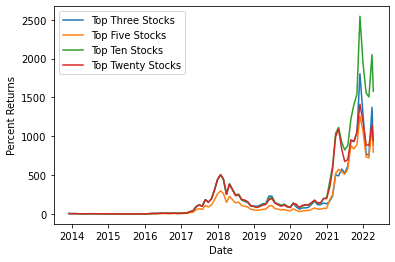

In [238]:
# graphs for each portfolio sizes' returns
# plots top three 1-month lookback returns in blue
plt.plot(topThree['cumulative_monthly_returns'], label='Top Three Coins')

# plots top five 1 month lookback returns in orange
plt.plot(topFive_1Months['cumulative_monthly_returns'], label='Top Five Coins')

# plots top 10 1 month lookback returns in green
plt.plot(topTen['cumulative_monthly_returns'], label='Top Ten Coins')

# plots top 20 1 month lookback returns in red
plt.plot(topTwenty['cumulative_monthly_returns'], label='Top Twenty Coins')


# relabels axes and creates legend
plt.xlabel("Date")
plt.ylabel("Percent Returns")
plt.legend()

# save figure
outgraph = r"C:\Qilin\Python\CryptoReturnsModelling\out\PortfolioSizesComparison.png"
plt.savefig(outgraph)

plt.show()

In [248]:
# Experiment with top five 2 months and different portfolio sizes
# driver code, we'll graph top 3, top 5, top 10, top 20
topThree_2Months = rebalancing(returns_df, 2, 3)
topThree_2Months = cumulativeReturns(topThree_2Months, 'monthly_returns')
print(topThree_2Months)

topTen_2Months = rebalancing(returns_df, 2, 10)
topTen_2Months = cumulativeReturns(topTen_2Months, 'monthly_returns')
print(topTen_2Months)

topTwenty_2Months = rebalancing(returns_df, 2, 20)
topTwenty_2Months = cumulativeReturns(topTwenty_2Months, 'monthly_returns')
print(topTwenty_2Months)

            monthly_returns  cumulative_monthly_returns
Datetime                                               
2013-12-31        -0.295352                   -0.295352
2014-01-31         0.106338                   -0.220420
2014-02-28        -0.311898                   -0.463569
2014-03-31        -0.150574                   -0.544342
2014-04-30        -0.111345                   -0.595077
...                     ...                         ...
2021-12-31        -0.241230                   62.717614
2022-01-31        -0.367566                   39.297178
2022-02-28         0.243842                   49.123341
2022-03-31         0.102578                   54.264893
2022-04-13        -0.315465                   36.830758

[101 rows x 2 columns]
            monthly_returns  cumulative_monthly_returns
Datetime                                               
2013-12-31        -0.295352                   -0.295352
2014-01-31         0.106338                   -0.220420
2014-02-28        -0.311

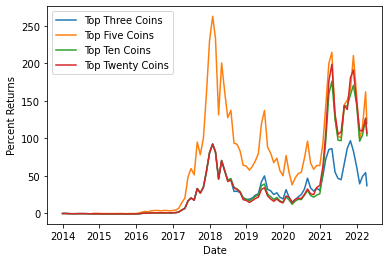

In [249]:
# graphs for each top 3, top 5, top 10, and top 20 with 2-month look-back periods
# plots top three 2 month lookback returns in blue
plt.plot(topThree_2Months['cumulative_monthly_returns'], label='Top Three Coins')

# plots top five two month lookback returns in orange
plt.plot(topFive_2Months['cumulative_monthly_returns'], label='Top Five Coins')

# plots top 10 two month lookback returns in green
plt.plot(topTen_2Months['cumulative_monthly_returns'], label='Top Ten Coins')

# plots top 20 3 month lookback returns in red
plt.plot(topTwenty_2Months['cumulative_monthly_returns'], label='Top Twenty Coins')


# relabels axes and creates legend
plt.xlabel("Date")
plt.ylabel("Percent Returns")
plt.legend()

# save figure
outgraph = r"C:\Qilin\Python\CryptoReturnsModelling\out\LookbackPortfolioSizesComparison.png"
plt.savefig(outgraph)

plt.show()